# Data Preparation
This notebook details the data preparation steps for Comper.

#### Before you start - libraries and user variables

In [60]:
import os, shutil
import random
import sys
import numpy as np
import pypianoroll
from matplotlib import pyplot as plt
import cPickle as pickle
import pianoroll_utils
from __future__ import print_function
import IPython

# User paths
LPD5_DIR = "./lpd_5_cleansed"
DATA_DIR = "./pianorolls_200"
NUM_FILES = 200
PICKLE_FILE = './pickle_jar/units_200_songs_clipped88.pkl'
NORM_PICKLE_FILE = './pickle_jar/norm_units_200_songs_clipped88.pkl'

# Music shape
MIN_PITCH = 21 # A-1 (MIDI 21)
MAX_PITCH = 108 # C7 (MIDI 108)
BEATS_PER_UNIT = 4
NUM_TRANSPOSITIONS = 3 # Number of transpositions to perform (maximum 12)

# Don't change unless you know what you're doing
BEAT_RESOLUTION = 24 # This is set by the encoding of the lpd-5 dataset, corresponds to number of ticks per beat
PARTITION_NOTE = 60 # Break into left- and right-accompaniments at middle C
NUM_PITCHES = MAX_PITCH - MIN_PITCH + 1
TICKS_PER_UNIT = BEATS_PER_UNIT * BEAT_RESOLUTION
MEAN_THRESHOLD = 0.5 # Filter out units with mean values less than 0.5

## 1. File preparation

### 1.1 Download the dataset

1. Go to [https://salu133445.github.io/musegan/dataset](https://salu133445.github.io/musegan/dataset)
2. Download the `lpd-5-cleansed.tgz` dataset.
3. Extract it into a folder `lpd-5-cleansed`.
4. You should see three layers of subfolders labelled 'A'-'J', and then leaf folders named something like `TRJJFLV128F92FC46E/`, each containing a file which looks something like `c28d6d22cf7298890c5cc5f21ac2244d.npz` (this is a numpy zip file, more information [here](https://salu133445.github.io/pypianoroll/save_load.html))

### 1.2 Flatten all files into one folder

In [15]:
%%bash
DATASET_PATH = "./lpd_5_cleansed"

# `cd` to the root of your dataset.
cd $DATASET_PATH

# Check that there are 24474 .npz files
find . -mindepth 2 -type f | wc -l

# Move all files to the current directory for easier access later
# What? https://askubuntu.com/questions/146634/shell-script-to-move-all-files-from-subfolders-to-parent-folder
find . -mindepth 2 -type f -print -exec mv --backup=numbered {} . \;

# Rename all "~#~" extensions to "~#.npz" so that numpy doesn't reject the file later on.
rename 's/\~$/\.npz/' *~

# Remove the empty folders `rm -r */` (Don't forget the slash!)
rm -r */

# Confirm that you have the correct number of files using `ls | wc -l`.
ls | wc -l

### 1.3 Grab a random subset of files to play with

In [2]:
# Create a new directory for our pianorolls
if not os.path.isdir(DATA_DIR):
    os.mkdir(DATA_DIR)
    # Grab a random subset of files from our LPD5 dataset to play with
    files_subset = random.sample(os.listdir(LPD5_DIR), NUM_FILES) # Sampling without replacement
    for filename in files_subset:
        src = os.path.join(LPD5_DIR, filename)
        dest = os.path.join(DATA_DIR, filename)
        shutil.copyfile(src, dest)
    print("Copied", NUM_FILES, "files to", DATA_DIR, ".")
else:
    print("Directory already exists.")

# Print the first 10 files of our chosen subset
print(os.listdir(DATA_DIR)[:10])

Copied 200 files to ./pianorolls_200 .
['7070bae9a829c96b2412340ae6ce890c.npz', '45920614bd3142da383f8b6a583b9ebd.npz.~1.npz', 'c2081845e1c633afe6ef43db10574a2c.npz', '70a54e8b989321aa6544587fdadd91e6.npz.~1.npz', 'c95691cdb995ff18ed327ab73d548503.npz', '2c49fbc1548bc49b5bec2703763c1622.npz', '09ecccd34acbbe01a0a438a314a4d35d.npz.~1.npz', '9f96135bcc87cb059bf13cfd0847d3fe.npz.~8.npz', 'e6a45119fa4e8a891fb0fbede49cbad9.npz', 'ff98877f1aa0e94007c79738edf96851.npz.~1.npz']


### 1.4 [Optional] Inspect the data

From the MuseGAN page:

> In LPD-5, the tracks of each multi-track piano-rolls are merged into five common categories: bass, drums, piano, guitar and strings according to the program numbers provided in the MIDI files. Note that instruments out of the list are considered as part of the strings

We use [pypianoroll](https://github.com/salu133445/pypianoroll), created by the authors of MuseGAN to manipulate the data. The pypianoroll library gives us a ton of helpful methods which makes it easy to find out more about each file. (pypianoroll [docs](https://salu133445.github.io/pypianoroll/index.html))

In [4]:

def printInfo(track):
    print("\n#####################")
    print("Name: ", track.name)
    print("isDrum: ", track.is_drum)
    print("Program: ", track.program)
    if len(track.pianoroll):
        print("Active length: ", track.get_active_length())
        print("Active pitch range: ", track.get_active_pitch_range())
    else:
        print("Empty pianoroll.")
    print("")

# Pick a file to look at
filename = random.choice(os.listdir(DATA_DIR))
print(filename)
# Load pianoroll file as a multitrack object
multi = pypianoroll.Multitrack(os.path.join(DATA_DIR, filename))
print("Tempo: ", multi.tempo)
print("Beat resolution: ", multi.beat_resolution)
# Show some info about the pianoroll
for track in multi.tracks:
    printInfo(track)


4bb57ca1fe668633004037846cf0a65f.npz.~1.npz
Tempo:  [135.00256505 135.00256505 135.00256505 ... 135.00256505 135.00256505
 135.00256505]
Beat resolution:  24

#####################
Name:  Guitar
isDrum:  False
Program:  24
Empty pianoroll.


#####################
Name:  Piano
isDrum:  False
Program:  0
Active length:  12270
Active pitch range:  (28, 105)


#####################
Name:  Bass
isDrum:  False
Program:  32
Empty pianoroll.


#####################
Name:  Drums
isDrum:  True
Program:  0
Active length:  12265
Active pitch range:  (35, 64)


#####################
Name:  Strings
isDrum:  False
Program:  48
Empty pianoroll.



## 2. Load pianorolls

In the following, we extract pianoroll matrices from each of the .npz files we obtained during file preparation. We will also apply some data preprocessing and augmentation steps:

### Data preprocessing
- We clip the velocity values between 0-127. This is essential since later we assume the maximum to be 127 when normalizing the vectors before training/testing. It is not very clear why the values are not already contained within 0-127, but the original dataset appears to have some velocity values up to 500, so we simply clamp all values to be certain.
- Also, we "crop" the matrices to match the MIN_PITCH, MAX_PITCH parameters defined above. This reduces the pitch space from 128 to something smaller, since in most songs there will not be notes at the extreme ends of the MIDI pitch spectrum (for comparison, standard pianos only have 88 pitches).

### Data augmentation
Melody and harmony are portable - in the sense that so long as relative intervals are maintained, the starting pitch, or the key of the music, can be transposed freely. In that sense, using for instance a 127-pitch system, each song in our dataset can actually be transposed into 127 equally valid songs. However, in most cases pianists tend to stick around the center of the keyboard, so we are only interested in teaching our model the concept of key-invariance, for which we need to represent each song in 12 different keys (the number of semitones in an octave).

Transposition is achieved quite simply in a pianoroll representation. For a key shift of 1 semitone, we simply shift all data in the pianoroll matrix up by one row (along the pitch axis). We perform data augmentation by shifting each pianoroll between -5 and +6 semitones, to create 12\* copies of each song in different keys (including the original key). 

\* <i>An option NUM\_TRANSPOSITIONS is given to allow for fewer transpositions to be made, to save space/computation time.</i>


In [59]:
print("Collecting pianorolls from {} files. This might take a few minutes...".format(len(os.listdir(DATA_DIR))))

pianorolls = [] # List to hold all our piano rolls

for filename in os.listdir(DATA_DIR):
    # Load pianoroll file as a multitrack object
    multi = pypianoroll.Multitrack(os.path.join(DATA_DIR, filename))
    for track in multi.tracks:
        # Non-empty piano pianoroll
        if track.name == "Piano" and track.pianoroll.shape[0] > 0:
            proll = track.pianoroll
            # Make sure velocities are between 0-127
            proll = proll.clip(0, 127)
            # Crop pitch range of pianoroll
            proll = pianoroll_utils.crop_pianoroll(proll, MIN_PITCH, MAX_PITCH)
            # Transpose each pianoroll NUM_TRANSPOSITIONS times
            for i in np.random.choice(range(-5,7), NUM_TRANSPOSITIONS, replace=False):
                transposed_proll = pianoroll_utils.get_transposed_pianoroll(proll, i)
                pianorolls.append(transposed_proll)
                # Print status
                print(".", end='')
                if len(pianorolls) % 100 == 0:
                    print(len(pianorolls))

print("Done.")
print("Collected {} pianorolls of shape (ticks, {})".format(len(pianorolls), pianorolls[0].shape[1]))

OSError: [Errno 2] No such file or directory: './pianorolls_50'

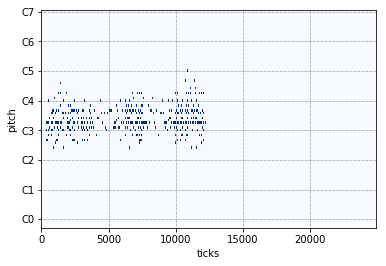

In [9]:
# Visualize a random pianoroll
pianoroll = random.choice(pianorolls)
fig1, ax1 = plt.subplots()
pianoroll_utils.plot_pianoroll(ax1, pianoroll, MIN_PITCH, MAX_PITCH)

## 3. Unit sampling

### 3.1 Overview


Our model deals with predicting musical _units_ of a pianoroll, which can be for example 4 beats of a pianoroll depending on the chosen `BEATS_PER_UNIT`. The datasets we prepare must then correspond to input/output pairs of musical units.

#### Model objectives

Given an input unit at time $t$, predict an output unit which may be either (depending on a user-selected prediction mode)
1. The following unit at time $t+1$
2. An accompaniment unit at time $t$
3. An accompaniment unit at time $t+1$

In the 1st case, the output is simply the _next-step prediction_, used commonly by most composition algorithms. 

In the 2nd case, the output is an _accompanying pianoroll of the current unit_, either the left-accompaniment or right-accompaniment. For example, given an input pianoroll which is a right-accompaniment, the model will be expected to predict the left-accompaniment for that input.

In the 3rd (expectedly most difficult) case, the output is an _accompanying pianoroll of the next unit_, either the left-accompaniment or right-accompaniment. For example, given an input pianoroll which is a right-accompaniment, the model will be expected to predict the left-accompaniment at the next time step.

#### Unit creation

To help the model learn accompaniments, we split each pianoroll from our dataset into two complementary pianorolls which serve as accompaniments for each other. This is done in a naive way, using the `PARTITION_NOTE` as the splitting point to divide the pianoroll along the pitch axis into left- and right- accompaniments (as in left and right hand of a piano player). This approach was inspired by \[Bretan et al\]. 

Each of these pianoroll segments (of fixed tick-length and only containing notes for either left- or right- accompaniments) will be used as a single unit, and is represented by a matrix of shape `[TICKS_PER_UNIT, NUM_PITCHES=128]`. 

The input and output matrices of our model will have the same shape.

#### Data structure

Since all units have the same shape, this makes it easy to store the data as a 3-dimensional matrix of depth $M$, where $M$ is the number of units (data points).

We will create 4 matrices comprising of: the input units, the next step units, the accompaniment units, and the next step accompaniment units. 

```
input_units.shape = [M, TICKS_PER_UNIT, NUM_PITCHES]
input_units_next.shape = [M, TICKS_PER_UNIT, NUM_PITCHES]
comp_units.shape = [M, TICKS_PER_UNIT, NUM_PITCHES]
comp_units_next.shape = [M, TICKS_PER_UNIT, NUM_PITCHES]
```

The unit dimension is ordered are ordered such that the $i$-th input has an output at the $i$-th element of each output matrix. (eg. given `input_units[i,:,:]`, the model should predict `input_units_next[i,:,:]`, `comp_units[i,:,:]`, or `comp_units_next[i,:,:]`)

#### Filtering out near-empty units

When we plot a full pianoroll, it becomes clear that many of the units we extract from the roll will be close to empty. Since these units don't hold any useful information, we discard them by filtering out any units with a mean value smaller than `MEAN_THRESHOLD`. It is expected that the mean of a non-empty unit will have a value comparable to 1, since non-normalized pianorolls have values between $[0,127]$, and there are 127 pitch classes. Hence a full-velocity single note at one tick instance will have a mean value of 1.

For example, a `MEAN_THRESHOLD` of 0.5 means that we wish to keep only units that on average, have at least a half-velocity note at each tick.

Overall unit means:  1.488120876099707
Before filtering:  (31, 96, 88)
Filter threshold:  0.5
After filtering:  (28, 96, 88)


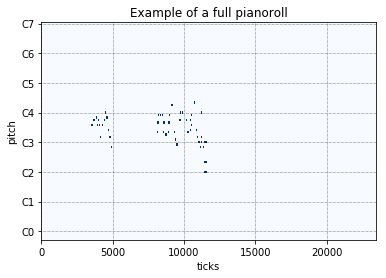

In [10]:
# Investigating the effect of different thresholds
pianoroll = random.choice(pianorolls)
fig, ax = plt.subplots()
ax.set_title("Example of a full pianoroll")
pianoroll_utils.plot_pianoroll(ax, pianoroll, MIN_PITCH, MAX_PITCH)

# Without filtering
[input_units, input_units_next, comp_units, comp_units_next] = pianoroll_utils.create_units(pianoroll,
                                                                                            NUM_PITCHES,
                                                                                            TICKS_PER_UNIT,
                                                                                            PARTITION_NOTE)
input_units_means = np.mean(input_units, axis=(1,2)).squeeze()
print("Overall unit means: ", np.mean(input_units_means))
print("Before filtering: ", input_units.shape)

# Filter out empty units
print("Filter threshold: ", MEAN_THRESHOLD)
[input_units, input_units_next, comp_units, comp_units_next] = pianoroll_utils.create_units(pianoroll,
                                                                                            NUM_PITCHES,
                                                                                            TICKS_PER_UNIT,
                                                                                            PARTITION_NOTE,
                                                                                            MEAN_THRESHOLD)
print("After filtering: ", input_units.shape)

### 3.2 Take units from all pianorolls

In [16]:
units = {} # Dictionary to store all data
units["input"] = np.array([]).reshape(0, TICKS_PER_UNIT, NUM_PITCHES)
units["comp"] = np.array([]).reshape(0, TICKS_PER_UNIT, NUM_PITCHES)

for i, pianoroll in enumerate(pianorolls):
    print(".", end='')
    if i % 100 == 0:
        print(i)
    # Get the units for this pianoroll
    [input_units, comp_units] = pianoroll_utils.create_units(pianoroll, NUM_PITCHES, TICKS_PER_UNIT,
                                                            PARTITION_NOTE, MIN_PITCH, MEAN_THRESHOLD)
    # Append it to the full dataset
    units["input"] = np.concatenate([units["input"], input_units], axis=0)
    units["comp"] = np.concatenate([units["comp"], comp_units], axis=0)
    
print("Done extracting units.")

# Print info
print("Collected {} units from {} pianorolls.".format(units["input"].shape[0], len(pianorolls)))
print("input_units.shape: ", units["input"].shape)
print("comp_units.shape: ", units["comp"].shape)

# Save data in a pickle file
if not os.path.isdir(os.path.dirname(PICKLE_FILE)):
    os.mkdir(os.path.dirname(PICKLE_FILE))
with open(PICKLE_FILE, 'wb') as outfile:
    pickle.dump(units, outfile, protocol=pickle.HIGHEST_PROTOCOL)
print("Pickled units to", PICKLE_FILE)

.0
....................................................................................................100
....................................................................................................200
....................................................................................................300
....................................................................................................400
.......Done extracting units.
Collected 20559 units from 408 pianorolls.
input_units.shape:  (20559, 96, 88)
comp_units.shape:  (20559, 96, 88)
Pickled units to ./pickle_jar/units_200_songs_clipped88.pkl


In [4]:
# Load pickled units
units = {}
with open(PICKLE_FILE, 'rb') as infile:
    units = pickle.load( infile )

# Print info
print("Loaded", units["input"].shape[0], "units from", PICKLE_FILE)
print("input_units.shape: ", units["input"].shape)
print("comp_units.shape: ", units["comp"].shape)

Loaded 3728 units from ./pickle_jar/units_50_songs_clipped88.pkl
input_units.shape:  (3728, 96, 88)
comp_units.shape:  (3728, 96, 88)


### 3.3 Save an alternate set for deep learning tasks (normalized and axes swapped)

In [17]:
norm_units = {}
# Change from [M, ticks, pitches] to [M, pitches, ticks, channels=1]
norm_units["input"] = units["input"].swapaxes(1,2).reshape(len(units["input"]), NUM_PITCHES, TICKS_PER_UNIT)
norm_units["comp"] = units["comp"].swapaxes(1,2).reshape(len(units["comp"]), NUM_PITCHES, TICKS_PER_UNIT)
# Normalize values between 0 and 1
norm_units["input"] = norm_units["input"].astype('float32') / 127. # 0-127 is the unnormalized velocity range
norm_units["comp"] = norm_units["comp"].astype('float32') / 127. # 0-127 is the unnormalized velocity range
print("Reshaped:", norm_units["input"].shape)

# Save data in a pickle file
if not os.path.isdir(os.path.dirname(NORM_PICKLE_FILE)):
    os.mkdir(os.path.dirname(NORM_PICKLE_FILE))
with open(NORM_PICKLE_FILE, 'wb') as outfile:
    pickle.dump(norm_units, outfile, protocol=pickle.HIGHEST_PROTOCOL)
print("Pickled units to", NORM_PICKLE_FILE)

del norm_units

Reshaped: (20559, 88, 96)
Pickled units to ./pickle_jar/norm_units_200_songs_clipped88.pkl


### 3.4 Visualize and listen to our units!

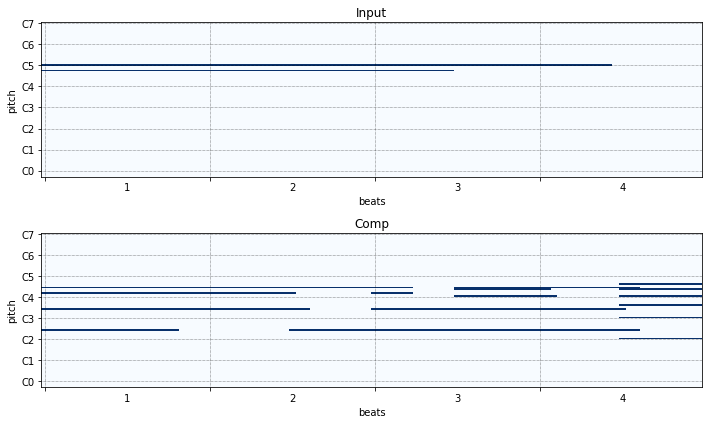

In [49]:
# Plot random input unit along with corresponding next and comp units
unit_index = np.random.randint(units["input"].shape[0])
input_unit = units["input"][unit_index]
comp_unit = units["comp"][unit_index]

# Plot comparison
fig, ax = plt.subplots(2,1)
fig.set_size_inches(10, 6, forward=True)
ax[0].set_title('Input')
ax[1].set_title('Comp')
pianoroll_utils.plot_pianoroll(ax[0], input_unit, MIN_PITCH, MAX_PITCH, beat_resolution=24)
pianoroll_utils.plot_pianoroll(ax[1], comp_unit, MIN_PITCH, MAX_PITCH, beat_resolution=24)
fig.tight_layout()

In [63]:
reload(pianoroll_utils)
# pianoroll_utils.pianoroll_2_events??

<module 'pianoroll_utils' from 'pianoroll_utils.pyc'>

In [64]:
# Listen to the MIDI files
audio0 = pianoroll_utils.play_pianoroll(input_unit.T, MIN_PITCH, MAX_PITCH, '0')
IPython.display.display(IPython.display.Audio(audio0))

audio1 = pianoroll_utils.play_pianoroll(comp_unit.T, MIN_PITCH, MAX_PITCH, '1')
IPython.display.display(IPython.display.Audio(audio1))

# Listen to the input with the comp
audio2 = pianoroll_utils.play_pianoroll(input_unit.T + comp_unit.T, MIN_PITCH, MAX_PITCH, '2')
IPython.display.display(IPython.display.Audio(audio2))

## 4. Tokenization

Look into the possibility of treating every unique pianoroll tick (column) as a token "word". This clearly has unimaginably large (2^128) possibilities, but only a small subset of those are used in practice. This is comparable to tokenization of english words, for which the number of alphabet possibilities are infinite but you can still use one-hot encodings successfully.

### 4.1 Investigate the number of tokens required

In [7]:
from __future__ import print_function

def get_tokens(pianoroll, num_pitches=128):
    """
    Given a pianoroll matrix of shape (128, N),
    returns a Python set of M tuples corresponding 
    to M unique columns in the matrix.
    """
    assert pianoroll.shape[0] == num_pitches
    tokens = np.unique(pianoroll, axis=1).T
    tokens = tuple(map(tuple, tokens))
    assert len(tokens[0]) == num_pitches
    return set(tokens)

all_tokens = set()
num_tokens = []
new_tokens = 0
num_new_tokens = []
for i, proll in enumerate(pianorolls):
    # Change to shape (128, N)
    proll = proll.T
    # Change to binary (0 or 1) velocity
    proll[proll > 0] = 1
    # Return set of unique tokens
    tokens = get_tokens(proll, num_pitches=NUM_PITCHES)
    # Union with the set of all tokens
    all_tokens = all_tokens.union(tokens)

    num_tokens.append(len(all_tokens))
    new_tokens += len(tokens)
    num_new_tokens.append(new_tokens)
    # Print status
    print(".", end='')
    if i % 50 == 0:
        print(i)

print("New tokens = {}".format(len(tokens)))
print("Total unique tokens = {}".format(len(all_tokens)))

........................................................................................................................................................................................................................................................................................................................................................................................................................

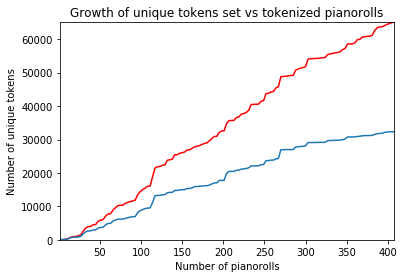

In [8]:
plt.plot(np.arange(1, len(pianorolls)+1), num_new_tokens, 'r')
plt.plot(np.arange(1, len(pianorolls)+1), num_tokens)
plt.axis([1, len(pianorolls), 0, new_tokens])
plt.title('Growth of unique tokens set vs tokenized pianorolls')
plt.xlabel('Number of pianorolls')
plt.ylabel('Number of unique tokens')
plt.show()

### 4.2 Convert pianorolls to tokenized pianorolls

Tutorials on word embeddings (word2vec):
- deeplearning4j [tutorial](https://deeplearning4j.org/word2vec.html)
- Keras [tutorial](http://adventuresinmachinelearning.com/word2vec-keras-tutorial/) on Adventures In Machine Learning blog